### Create synthetic data

Before we apply our customized loss functions on real world stock price data, we will set up some synthetic time series data. The aim is to have **4 input series** and **1 target** series. In particular, we use:

- 2 **long wave sin** functions with similar base frequency but different amplitude to set the large scale trend. These series are highly correlated, on purpose. 
- Additionally, we add 1 **short wave sin** function for adding some small scale fluctuations. This feature is supposed to be linearly independent of the 2 long wave functions. 
- Ultimately, we add 1 **noise** series which is randomly drawn. 

The **target** series is the (weighted) **sum of all 4 series**.

In [174]:
# Import libraries:
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed, Input, Dense, Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, GaussianNoise, LeakyReLU
from tensorflow.keras.layers import concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, Adagrad, Nadam, RMSprop, schedules
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.datasets as tfds
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

In [162]:
## Create some data:

# Set number of desired time steps:
n_steps = 1000

# Create linear space for time axis:
t_linspace = np.linspace(0, 10*np.pi, n_steps)

# Create (reproducible) random numbers, drawn from a normal distribution:
np.random.seed(1)
rand_normal_1 = np.random.normal(0, 0.1, n_steps)
np.random.seed(2)
rand_normal_2 = np.random.normal(0, 0.1, n_steps)
np.random.seed(3)
rand_normal_3 = np.random.normal(0, 0.1, n_steps)

# Create two long wave sin series:
input_1 = 0.5*np.sin(t_linspace)+5*rand_normal_1
input_2 = np.sin(t_linspace+5*rand_normal_1)

# Create single short wave sin series:
input_3 = 0.5*np.sin(3*t_linspace)+5*rand_normal_2

# Create noise series:
input_4 = 3*rand_normal_3

# Stack inputs:
inputs = np.stack([input_1,input_2,input_3,input_4],axis=1)

# Create target, as weighted sum of all inputs:
target = 0.1*input_1 + 0.2*input_2 + input_3 + input_4

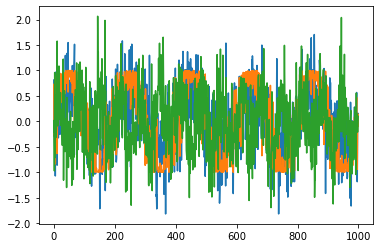

In [157]:
# Get familiar with inputs and target:
plt.plot(input_1)
plt.plot(input_2)
plt.plot(input_3)
# plt.plot(input_4)
# plt.plot(target)

In [155]:
# Check correlation of input series 1 and 2:
np.corrcoef(np.stack([input_1,input_2]))

array([[1.        , 0.54729807],
       [0.54729807, 1.        ]])

In [163]:
# Define function to split time series 'sequence' into 'n_steps'
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # Find the end of this pattern
        end_ix = i + n_steps
        # Check if we are beyond the sequence
        if end_ix > len(sequence):
            break
        # Gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
    return np.array(X)

In [166]:
# Split input values into sequences of specified input length:
input_length = 20
inputs_split = split_sequence(inputs, input_length)

# Adjust targets: Cut first (input_length - 1) entries
target_cut = target[input_length-1:]

# Check dimensions:
print("inputs shape AFTER splitting (samples, timesteps, input features): ", inputs_split.shape)
print("target shape AFTER removing (input_length - 1) entries: ", target_cut.shape)

inputs shape AFTER splitting (samples, timesteps, input features):  (981, 20, 4)
target shape AFTER removing (input_length - 1) entries:  (981,)


In [169]:
## Split inputs and target into train and validation data:

# Specify rel. amount of train data:
train_val_split = 0.8

# Get corresponding number of train samples:
n_train = int(len(inputs) * train_val_split)

# Split inputs and target:
train_input = inputs_split[:n_train]
val_input = inputs_split[n_train:]
train_target = target_cut[:n_train]
val_target = target_cut[n_train:]

# Check dimensions:
print("INPUTS:")
print("=======")
print("train_input shape (samples, timesteps, input features): ", train_input.shape)
print("val_input shape (samples, timesteps, input features): ", val_input.shape)

print("\nTARGETS:")
print("=======")
print("train_target shape (samples, timesteps, input features): ", train_target.shape)
print("val_target shape (samples, timesteps, input features): ", val_target.shape)

INPUTS:
train_input shape (samples, timesteps, input features):  (800, 20, 4)
val_input shape (samples, timesteps, input features):  (181, 20, 4)

TARGETS:
train_target shape (samples, timesteps, input features):  (800,)
val_target shape (samples, timesteps, input features):  (181,)


In [185]:
# Set model parameters:
weight_init = tfi.glorot_uniform()
bias_init = tfi.Zeros()
batch_size = 1
n_epochs = 20
learning_rate=0.0001
input_shape = (input_length, train_input.shape[-1]) # (time steps, features)

In [186]:
# Define and compile model:
model = Sequential()
model.add(Conv1D(filters=10, kernel_size=7, input_shape=input_shape, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2)) 
model.add(Conv1D(filters=20, kernel_size=5, strides=1, kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.3))
#model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(20, activation = 'sigmoid', kernel_initializer=weight_init, bias_initializer = bias_init))
model.add(Dense(1, name = "output", activation = 'linear', kernel_initializer=weight_init, bias_initializer = bias_init))
   
# Use classic mse loss:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=([]))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 14, 10)            290       
_________________________________________________________________
batch_normalization_8 (Batch (None, 14, 10)            40        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 10)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 10, 20)            1020      
_________________________________________________________________
batch_normalization_9 (Batch (None, 10, 20)            80        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 10, 20)            0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 200)              

In [187]:
# Train model:
history = model.fit(train_input, train_target, epochs=n_epochs, batch_size=batch_size,
                    shuffle=True, verbose=1, validation_data=(val_input, val_target))

Epoch 1/20
800/800 [==============================] - 1s 942us/step - loss: 0.5614 - val_loss: 0.5557
Epoch 2/20
800/800 [==============================] - 0s 565us/step - loss: 0.4639 - val_loss: 0.5445
Epoch 3/20
800/800 [==============================] - 0s 568us/step - loss: 0.4042 - val_loss: 0.5321
Epoch 4/20
800/800 [==============================] - 0s 565us/step - loss: 0.4161 - val_loss: 0.5259
Epoch 5/20
800/800 [==============================] - 0s 582us/step - loss: 0.4494 - val_loss: 0.5260
Epoch 6/20
800/800 [==============================] - 0s 574us/step - loss: 0.4114 - val_loss: 0.5224
Epoch 7/20
800/800 [==============================] - 0s 566us/step - loss: 0.3608 - val_loss: 0.5039
Epoch 8/20
800/800 [==============================] - 0s 565us/step - loss: 0.3258 - val_loss: 0.5111
Epoch 9/20
800/800 [==============================] - 0s 565us/step - loss: 0.2908 - val_loss: 0.4941
Epoch 10/20
800/800 [==============================] - 0s 564us/step - loss: 0.275